In [77]:
import torch
import torch.nn as nn
import torch.optim  as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from utils.utils import *
os.environ['KMP_DUPLICATE_LIB_OK']='True' # add this, otherwise the model will easily died because of plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

In [78]:
device

'cuda'

In [79]:
def get_layer_output(layers, x, layer_choosed):
    output_lst = []
    for i in range(len(layers)):
        x = layers[i](x)
        if i in layer_choosed: 
            output_lst.append(x)
    return output_lst


def get_selected_layer_output(layers, x, layer_choosed):
    for i in range(len(layers)):
        x = layers[i](x)
        if i == layer_choosed: 
            return x

def compute_GRAM_matrix(input_data):
    _, c, h, w = input_data.shape
    input_data = input_data.squeeze().view(c, h*w)
    return input_data @ input_data.T

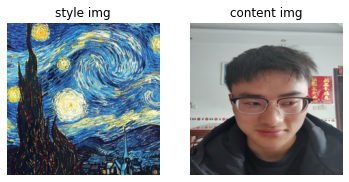

In [83]:
content_img = Image.open("./imgs/tao.jpg").convert("RGB").resize((224, 224))
style_img = Image.open("./imgs/starrynight.jpg").convert("RGB").resize((224, 224))
plt.subplot(1, 2, 1)
plt.imshow(style_img)
plt.title("style img")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(content_img)
plt.title("content img")
plt.axis("off")
content_img = preprocess(content_img).unsqueeze(0)
style_img = preprocess(style_img).unsqueeze(0)

In [84]:
model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
layers = model.features[:11].to(device)

In [85]:
# make the relu's inplace = false
for i in range(len(layers)):
    if isinstance(layers[i], nn.ReLU):
        layers[i] = nn.ReLU(inplace=False)
layers

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [86]:
# params
LEARNING_RATE = 5e-3
ITER_NUM = 2000
WEIGHT_CONTENT = 1
WEIGHT_STYLE = 1e9
LAYER_FOR_STYLE = [0, 2, 5, 7, 10]
LAYER_FOR_CONTENT = 7
WIGHT_OF_GRAM_MATRIX = [1, 1, 1, 1, 1]

iter (0), loss (226554101760.000000 style 226.554108 content 0.000000)


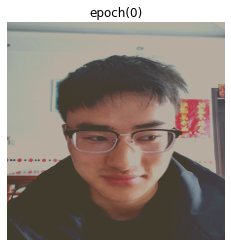

iter (200), loss (38800310272.000000 style 38.800312 content 36.599186)


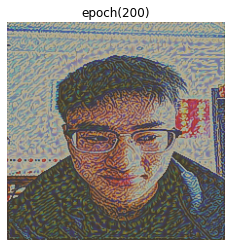

iter (400), loss (18467379200.000000 style 18.467379 content 41.718018)


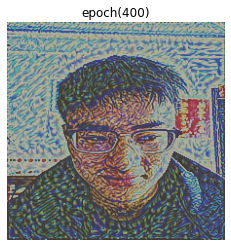

iter (600), loss (8049027584.000000 style 8.049027 content 42.748299)


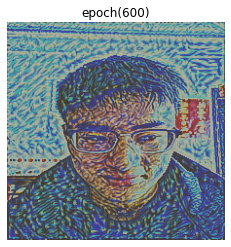

iter (800), loss (3678006528.000000 style 3.678007 content 43.225456)


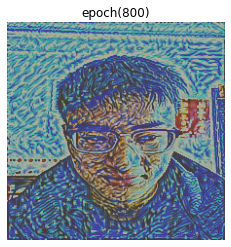

iter (1000), loss (2198086656.000000 style 2.198087 content 43.669399)


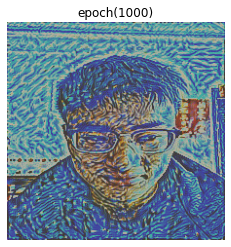

iter (1200), loss (1602193152.000000 style 1.602193 content 43.997902)


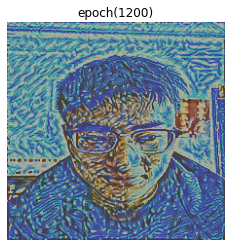

iter (1400), loss (1299469952.000000 style 1.299470 content 44.239288)


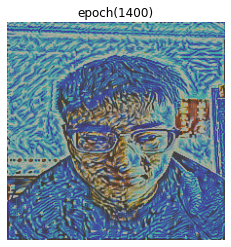

iter (1600), loss (1117638016.000000 style 1.117638 content 44.440510)


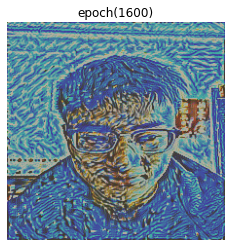

iter (1800), loss (996665856.000000 style 0.996666 content 44.623314)


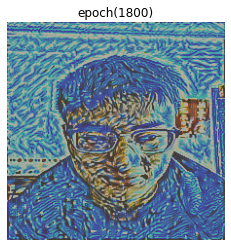

iter (2000), loss (909269760.000000 style 0.909270 content 44.788246)


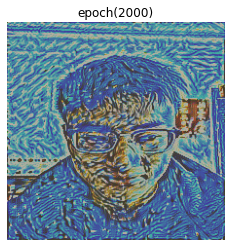

In [87]:
style_img = style_img.to(device)
content_img = content_img.to(device)

# compute content img's feature map
content_feature_map = get_selected_layer_output(layers, content_img, LAYER_FOR_CONTENT)

# compute style image's feature maps and then compute Gram matrix
style_feature_map = get_layer_output(layers, style_img, LAYER_FOR_STYLE)
style_GRAM_matrix = [compute_GRAM_matrix(each) for each in  style_feature_map]


# init a random noise, gradient descent on it to systhesis given texture.
"""
you can either start from a random noise, empty image, or the content img.
but use the content image is more easy, 
when using random noise, you  need to tune the content weight and tyle weight to make sure that:
the generated image looks like the content image, it may be annoying.
"""
noise = content_img.clone().requires_grad_(True)
# noise = Variable(torch.zeros(1, 3, 224, 224), requires_grad=True)
# noise = torch.randn(1, 3, 224, 224).requires_grad_(True)


# define optimizer and loss function
# remind the learning rate here must be large, otherwise you may see nothing.
optimizer = torch.optim.Adam([noise], lr=LEARNING_RATE) # use [] instead of list()
style_criterion = nn.MSELoss()
content_criterion = nn.MSELoss()

for iter in range(ITER_NUM + 1):
    noise_feature_map = get_selected_layer_output(layers, noise.to(device), LAYER_FOR_CONTENT)
    noise_feature = get_layer_output(layers, noise.to(device), LAYER_FOR_STYLE)
    noise_GRAM_matrix = [compute_GRAM_matrix(each) for each in noise_feature]

    # compute loss:
    # total loss = content loss + style loss
    # content loss is computed by content image's selected layers output
    # style loss is computed by style image's GRAM matrix

    # compute style loss    
    style_loss = 0
    for i in range(len(noise_GRAM_matrix)):
        N, M = style_feature_map[i].shape[1], style_feature_map[i].shape[2]
        style_loss += style_criterion(style_GRAM_matrix[i], noise_GRAM_matrix[i]) / (4 * N **2 * M **2 )

    # compute content loss
    content_loss = content_criterion(content_feature_map, noise_feature_map)

    total_loss = content_loss * WEIGHT_CONTENT + style_loss * WEIGHT_STYLE

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        torch.clamp_(noise, -1, 1)

    if iter % 200 == 0:
        print(f"iter ({iter}), loss ({total_loss:5f} style {style_loss:5f} content {content_loss:5f})")
        res = noise.clone()
        plt.imshow(deprocess(res.squeeze(0)))
        plt.title(f"epoch({iter})")
        plt.axis("off")
        plt.show()
deprocess(noise.squeeze(0)).save("./imgs/outputs/5. style transfer [1].png")